# Introduction
This colab notebook goes over the entire end-to-end development of our final image classification model for automated garbage sorting. We begin by acquiring and exploring our Kaggle dataset of waste images, analyzing class distribution, image characteristics, and the data integrity. Next, we preprocess the data, applying transformations and splitting it for training, validation, and testing. The core of the notebook focuses on fine-tuning a pre-trained ResNet-50 model, enhanced with Channel and Spatial Attention Modules (CBAM) and Multi-Scale Feature Fusion (MSFF), through a two-phase training strategy. Finally, we evaluate the model's performance on a test set, visualize its predictions, and save the trained model for future use. For more in-depth details on our decisions and thinking, please read our report.




## Global import of libraries we deemed necessary

In [ ]:
# For logistics and data examination
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torch import nn

## Getting the dataset from Kaggle

In [ ]:
from google.colab import files
files.upload()  # Upload the kaggle.json file from your account

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ishansingh423","key":"19628c1a5fcd4e5343de4514ce8e44bf"}'}

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!kaggle datasets download -d sumn2u/garbage-classification-v2

Dataset URL: https://www.kaggle.com/datasets/sumn2u/garbage-classification-v2
License(s): MIT
 87% 646M/744M [00:06<00:01, 58.8MB/s]
100% 744M/744M [00:06<00:00, 115MB/s] 


In [ ]:
!unzip garbage-classification-v2.zip -d /content/garbage_data/

Streaming output truncated to the last 5000 lines.
  inflating: /content/garbage_data/garbage-dataset/paper/paper_847.jpg  
  inflating: /content/garbage_data/garbage-dataset/paper/paper_848.jpg  
  inflating: /content/garbage_data/garbage-dataset/paper/paper_849.jpg  
  inflating: /content/garbage_data/garbage-dataset/paper/paper_851.jpg  
  inflating: /content/garbage_data/garbage-dataset/paper/paper_852.jpg  
  inflating: /content/garbage_data/garbage-dataset/paper/paper_853.jpg  
  inflating: /content/garbage_data/garbage-dataset/paper/paper_855.jpg  
  inflating: /content/garbage_data/garbage-dataset/paper/paper_856.jpg  
  inflating: /content/garbage_data/garbage-dataset/paper/paper_857.jpg  
  inflating: /content/garbage_data/garbage-dataset/paper/paper_859.jpg  
  inflating: /content/garbage_data/garbage-dataset/paper/paper_861.jpg  
  inflating: /content/garbage_data/garbage-dataset/paper/paper_863.jpg  
  inflating: /content/garbage_data/garbage-dataset/paper/paper_865.jpg  


## Understanding the class distribution

Number of classes (categories): 10
Class Distribution
biological: 997 images
shoes: 1977 images
trash: 947 images
metal: 1020 images
cardboard: 1825 images
plastic: 1984 images
paper: 1680 images
clothes: 5327 images
glass: 3061 images
battery: 944 images


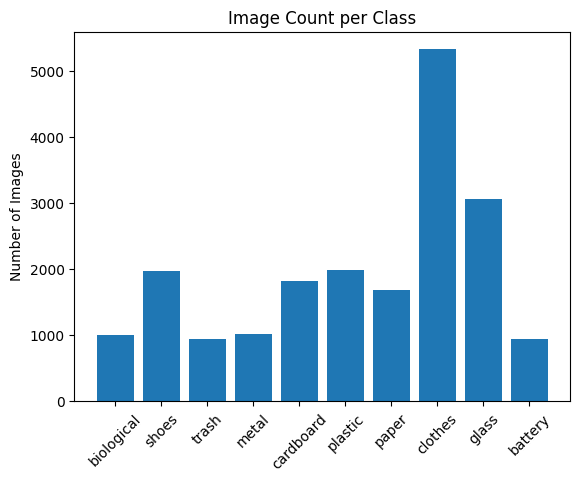

In [ ]:
dataset_path = '/content/garbage_data/garbage-dataset'

categories = os.listdir(dataset_path)
print(f"Number of classes (categories): {len(categories)}")

class_counts = {}

for category in categories:
    image_files = os.listdir(os.path.join(dataset_path, category))
    class_counts[category] = len(image_files)

print("Class Distribution")
for category, count in class_counts.items():
    print(f"{category}: {count} images")

plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
plt.title("Image Count per Class")
plt.ylabel("Number of Images")
plt.show()

The dataset contains 10 classes with a total of 18,762 images, but the class distribution is highly imbalanced. For example, the clothes class has 5,327 images, while glass has 3,061 and battery only 944. This imbalance could bias the model toward overrepresented classes, so techniques like class weighting, data augmentation, or resampling may be necessary during training to address it.

## Seeing images from each class

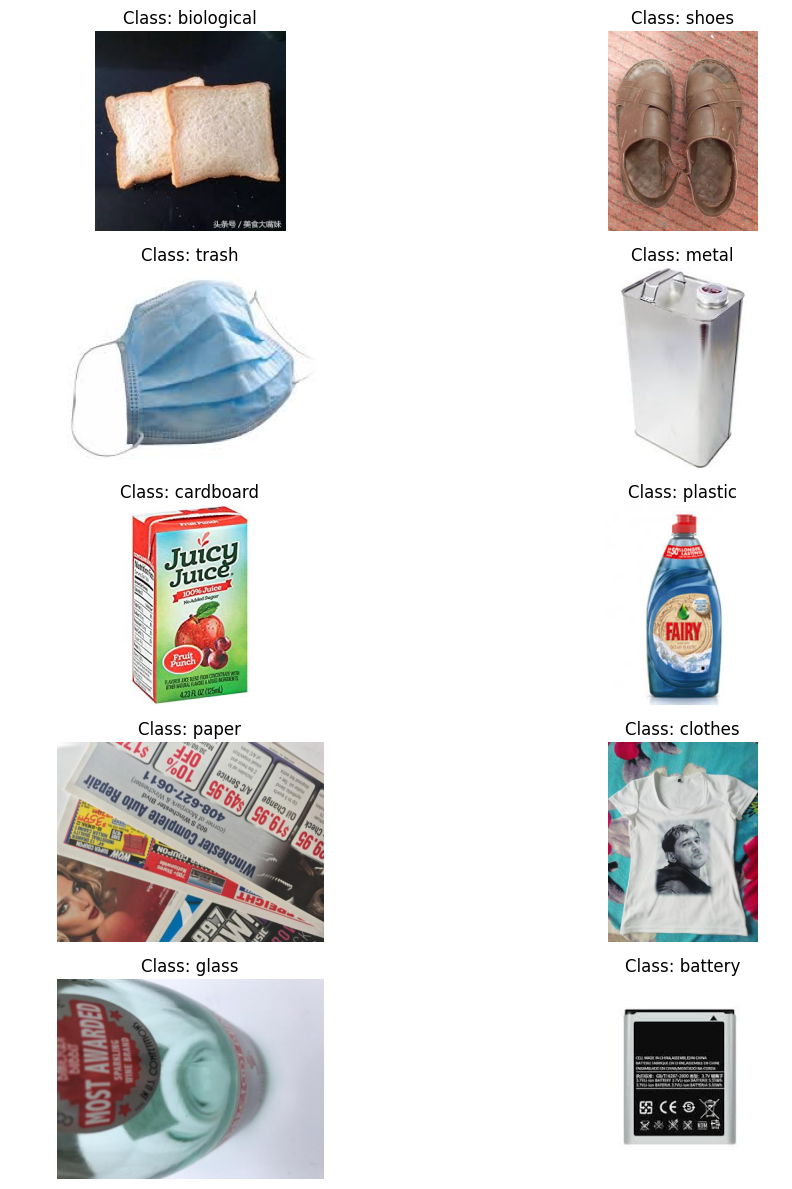

In [ ]:
plt.figure(figsize=(12, 12))

for idx, category in enumerate(categories):
    image_files = os.listdir(os.path.join(dataset_path, category))

    image_path = os.path.join(dataset_path, category, image_files[0])
    img = mpimg.imread(image_path)

    plt.subplot(5, 2, idx + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Class: {category}")

plt.tight_layout()
plt.show()

## Understanding the size of the images for pre-processing

In [ ]:
image_shapes = []

for category in categories:
    category_path = os.path.join(dataset_path, category)
    image_files = os.listdir(category_path)

    # Sampling the first 5 images from each class
    for file in image_files[:5]:
        img_path = os.path.join(category_path, file)
        img = Image.open(img_path)
        image_shapes.append(img.size)

print("Sample image sizes:", image_shapes[:10])


Sample image sizes: [(219, 230), (259, 195), (267, 189), (238, 212), (260, 194), (400, 533), (194, 259), (400, 711), (183, 275), (191, 264)]


The sample image sizes from the dataset show that the images vary significantly in both width and height, with dimensions ranging from small (e.g., 220×218) to relatively large (e.g., 512×384). This inconsistency suggests that the dataset will require resizing during preprocessing to ensure uniform input dimensions for the model.


## Looking for corrupt images

In [ ]:
corrupt_images = []

for category in categories:
    category_path = os.path.join(dataset_path, category)
    image_files = os.listdir(category_path)

    for file in image_files:
        img_path = os.path.join(category_path, file)
        try:
            img = Image.open(img_path)
            img.verify()  # Will raise an exception for corrupt files
        except Exception as e:
            corrupt_images.append(img_path)

print(f"Found {len(corrupt_images)} corrupt images.")

Found 0 corrupt images.


## Looking for duplicates using hashing

In [ ]:
import hashlib

def file_hash(filepath):
    with open(filepath, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

hashes = set()
duplicates = []

for category in categories:
    category_path = os.path.join(dataset_path, category)
    image_files = os.listdir(category_path)

    for file in image_files:
        file_path = os.path.join(category_path, file)
        h = file_hash(file_path)
        if h in hashes:
            duplicates.append(file_path)
        else:
            hashes.add(h)

print(f"Found {len(duplicates)} duplicate images.")

Found 0 duplicate images.


# Data Preprocessing
- Transformations (ex. convert to PyTorch tensor objects)
- Deduplication and Cleaning Data
- Loading and Splitting Data (train, validation, test)


### Deduplication and Data Cleaning




In [ ]:
# Above, we found 0 duplicate images, hence deduplication is complete.
# Also, to make sure our data was clean, we checked for corruption,
# and that also resulted in 0 corrupted images from our examination,
# hence data is clean and ready to be utilized.

### Tranform Data to Desired PyTorch Tensor Objects (+ Data Augmentation)

In [ ]:
# ImageNet statistics for normalization (required for pre-trained models)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    # More aggressive data augmentation for better generalization
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)), # Random crop and resize to 256x256
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30), # Increased rotation range
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1), # More aggressive color jitter
    transforms.ToTensor(),

    # IMPORTANT: Normalize with ImageNet statistics for transfer learning
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])


val_and_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),

    # IMPORTANT: Use same normalization as training
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

print("✓ Transforms configured with ImageNet normalization and enhanced data augmentation")

✓ Transforms configured with ImageNet normalization and enhanced data augmentation


This will tranform all our images to the desired and consistent size of 256 x 256 (we saw above that all classes had different image size dimensions, hence resizing is necessary), and convert to PyTorch tensors, the framework we will be using for our model training throughout this project. There are also options for data augmentation here, which we may enable later on if we see a lot of bias from training set.

### Loading & Splitting Data

In [ ]:
# Load
full_dataset = ImageFolder(dataset_path)

# Split: Train 70%, Validaiton 15%, Test 15%
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_test_dataset = random_split(full_dataset, [train_size, val_size + test_size])
val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size])

train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_and_test_transforms
test_dataset.dataset.transform = val_and_test_transforms

print(f"TOTAL dataset size:         {len(full_dataset)}")
print(f"Training set size (70%):    {len(train_dataset)}")
print(f"Validation set size (15%):  {len(val_dataset)}")
print(f"Test set size (15%):        {len(test_dataset)}")

TOTAL dataset size:         19762
Training set size (70%):    13833
Validation set size (15%):  2964
Test set size (15%):        2965


### Create Dataloaders

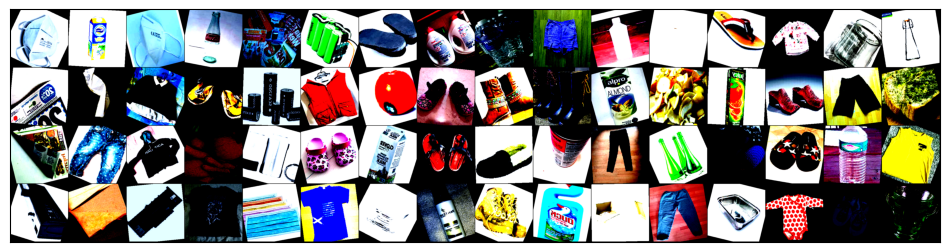

In [ ]:
# TODO: adjust as needed | UPDATE: seems like batch size 64 provides the best performance
batch_size = 64

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Visulaize a batch
dataiter = iter(train_loader)
images, labels = next(dataiter)
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))

# Model Training (Fine-Tuned Transfer Learning)

This section implements an efficient transfer learning approach using a pre-trained ResNet-50 model. Instead of training from scratch, we fine-tune existing features for our waste classification task.


## Model Architecture & Training Strategy

### Transfer Learning Approach
We use fine-tuning with a pre-trained ResNet-50 model instead of training from scratch, mainly due to these benefits:
- Leverages features learned from ImageNet (millions of images)
- Significantly faster convergence
- Better performance with limited data
- More efficient training

We will implment a "Two-Phase Training Strategy" as described below:
1. Phase 1 (Warm-up): We will train only the classifier head while keeping backbone frozen
   
2. Phase 2 (Fine-tuning): Now, we unfreeze and fine-tune deeper layers


## Defining the models (the PyTorch Modules)

In [ ]:
# Channel Attention Module (CAM)
class ChannelAttentionModule(nn.Module):
    def __init__(self, channel, reduction=16):
        super(ChannelAttentionModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channel, channel // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channel // reduction, channel, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

# Spatial Attention Module (SAM)
class SpatialAttentionModule(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttentionModule, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_concat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(x_concat)
        return self.sigmoid(out)

# Convolutional Block Attention Module (CBAM)
class CBAM(nn.Module):
    def __init__(self, channel, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttentionModule(channel, reduction)
        self.spatial_attention = SpatialAttentionModule(kernel_size)

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x

# Multi-Scale Feature Fusion (MSFF) Module
class MultiScaleFeatureFusion(nn.Module):
    def __init__(self, high_level_channels, low_level_channels, out_channels):
        super(MultiScaleFeatureFusion, self).__init__()
        # Adapting high-level features
        self.conv_high = nn.Conv2d(high_level_channels, out_channels, kernel_size=1, bias=False)
        self.bn_high = nn.BatchNorm2d(out_channels)

        # Adapting low-level features
        self.conv_low = nn.Conv2d(low_level_channels, out_channels, kernel_size=1, bias=False)
        self.bn_low = nn.BatchNorm2d(out_channels)

        # Final
        self.fuse_conv = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.fuse_bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, high_level_features, low_level_features):
        # Adapting channels
        high_adapted = self.relu(self.bn_high(self.conv_high(high_level_features)))
        low_adapted = self.relu(self.bn_low(self.conv_low(low_level_features)))

        # Upsampling high_adapted to match spatial size of low_adapted
        target_size = low_adapted.shape[2:]
        high_upsampled = F.interpolate(high_adapted, size=target_size, mode='bilinear', align_corners=False)

        fused = high_upsampled + low_adapted

        # Final
        out = self.relu(self.fuse_bn(self.fuse_conv(fused)))
        return out


# Enhanced model class with fine-tuning capabilities, CBAM, and MSFF integration
class EcoSortFineTunedModel(nn.Module):
    """
    Fine-tuned transfer learning ResNet-50 model with CBAM and Multi-Scale Feature Fusion (MSFF).
    Supports freezing/unfreezing layers for efficient training.
    """
    def __init__(self, num_classes, freeze_backbone=True):
        super(EcoSortFineTunedModel, self).__init__()

        # Pre-trained ResNet50
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

        # ResNet layers
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.avgpool = resnet.avgpool

        num_channels_layer4 = resnet.fc.in_features
        num_channels_layer3 = resnet.layer3[-1].conv3.out_channels

        self.cbam = CBAM(channel=num_channels_layer4)

        msff_out_channels = 512 # Output channels for the fused features
        self.msff = MultiScaleFeatureFusion(
            high_level_channels=num_channels_layer4,
            low_level_channels=num_channels_layer3,
            out_channels=msff_out_channels
        )

        # The input to the final classifier will now be from MSFF output after avgpool
        # Simplifing classifier head to reduce complexity and overfitting
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(msff_out_channels, num_classes)
        )

        # Freezing the feature extraction layers (backbone) for initial training
        if freeze_backbone:
            self.freeze_backbone()

    def freeze_backbone(self):
        """Freeze the base feature extraction layers (ResNet backbone)."""
        for param in self.conv1.parameters(): param.requires_grad = False
        for param in self.bn1.parameters(): param.requires_grad = False
        for param in self.layer1.parameters(): param.requires_grad = False
        for param in self.layer2.parameters(): param.requires_grad = False
        for param in self.layer3.parameters(): param.requires_grad = False
        for param in self.layer4.parameters(): param.requires_grad = False
        # CBAM, MSFF and classifier are trainable by default
        for param in self.cbam.parameters(): param.requires_grad = True
        for param in self.msff.parameters(): param.requires_grad = True
        for param in self.classifier.parameters(): param.requires_grad = True
        print("Backbone (base features) frozen - training CBAM, MSFF, and final classifier layers")

    def unfreeze_backbone(self, unfreeze_from_layer=4):
        """
        Unfreeze specified blocks of the ResNet backbone for fine-tuning.
        Args:
            unfreeze_from_layer (int): ResNet block index to start unfreezing from.
                                       4 (default): Unfreeze layer4.
                                       3: Unfreeze layer3 and layer4.
                                       ... to 1 for all layers.
        """
        # Making sure CBAM, MSFF and classifier are always trainable
        for param in self.cbam.parameters(): param.requires_grad = True
        for param in self.msff.parameters(): param.requires_grad = True
        for param in self.classifier.parameters(): param.requires_grad = True

        if unfreeze_from_layer <= 4:
            for param in self.layer4.parameters(): param.requires_grad = True
        if unfreeze_from_layer <= 3:
            for param in self.layer3.parameters(): param.requires_grad = True
        if unfreeze_from_layer <= 2:
            for param in self.layer2.parameters(): param.requires_grad = True
        if unfreeze_from_layer <= 1:
            for param in self.layer1.parameters(): param.requires_grad = True
            for param in self.conv1.parameters(): param.requires_grad = True
            for param in self.bn1.parameters(): param.requires_grad = True

        if unfreeze_from_layer <= 1:
            print("Backbone fully unfrozen for fine-tuning")
        elif unfreeze_from_layer <= 2:
            print("Backbone partially unfrozen for fine-tuning (ResNet layer2, layer3 & layer4)")
        elif unfreeze_from_layer <= 3:
            print("Backbone partially unfrozen for fine-tuning (ResNet layer3 & layer4)")
        elif unfreeze_from_layer <= 4:
            print("Backbone partially unfrozen for fine-tuning (ResNet layer4)")
        else:
            print("No additional backbone layers unfrozen.")


    def forward(self, x):
        # Base features
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        f3 = self.layer3(x)
        f4 = self.layer4(f3)

        f4_cbam = self.cbam(f4)

        # Applying Multi-Scale Feature Fusion
        # Pass both f4_cbam and f3 to MSFF
        fused_features = self.msff(f4_cbam, f3)

        x = self.avgpool(fused_features)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## Initializing model with frozen backbone

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = EcoSortFineTunedModel(num_classes=len(full_dataset.classes), freeze_backbone=True)
model = model.to(device)

# Just the trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,} ({100 * trainable_params / total_params:.2f}%)")


Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 175MB/s]


Backbone (base features) frozen - training CBAM, MSFF, and final classifier layers

Total parameters: 27,972,780
Trainable parameters: 4,464,748 (15.96%)


## Defining performance metric function

In [ ]:
@torch.no_grad()
def calculate_accuracy(model, dataloader, device):
    """
    Compute accuracy efficiently using batched inference
    Uses torch.no_grad() to prevent gradient computation during evaluation
    """
    model.eval()
    correct, total = 0, 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)

        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    model.train()
    return correct / total if total > 0 else 0.0


## Defining training function with proper fine-tuning

In [ ]:
def train_model_finetuned(model,
                          train_loader,
                          val_loader,
                          criterion,
                          optimizer,
                          scheduler,
                          num_epochs,
                          device,
                          early_stopping_patience=5,
                          checkpoint_path='best_model.pth'):
    """
    Train model with fine-tuning approach, early stopping, and checkpointing.

    Args:
        model: The neural network model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        num_epochs: Number of training epochs
        device: Device to train on (CPU/GPU)
        early_stopping_patience: Number of epochs to wait before early stopping
        checkpoint_path: Path to save best model
    """
    # Training tracking
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'learning_rates': []
    }

    best_val_acc = 0.0
    patience_counter = 0

    print("="*60)
    print("Starting Training")
    print("="*60)

    for epoch in range(num_epochs):
        # ============= Training Phase =============
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            # Move data to device (i.e. Colab's T4 GPU in our case)
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track statistics (detach to prevent memory leaks)
            running_loss += loss.item() * images.size(0)
            predictions = torch.argmax(outputs.detach(), dim=1)
            train_correct += (predictions == labels).sum().item()
            train_total += labels.size(0)

            # Print progress
            if (batch_idx + 1) % 10 == 0:
                print(f"  Batch [{batch_idx + 1}/{len(train_loader)}] - Loss: {loss.item():.4f}")

        # Calculate epoch training metrics
        epoch_train_loss = running_loss / train_total
        epoch_train_acc = train_correct / train_total

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * images.size(0)
                predictions = torch.argmax(outputs, dim=1)
                val_correct += (predictions == labels).sum().item()
                val_total += labels.size(0)

        epoch_val_loss = val_running_loss / val_total
        epoch_val_acc = val_correct / val_total

        # Update learning rate
        scheduler.step(epoch_val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        # Store history
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        history['learning_rates'].append(current_lr)

        # Print epoch summary
        print(f"\nEpoch [{epoch + 1}/{num_epochs}]")
        print(f"  Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f}")
        print(f"  Val Loss:   {epoch_val_loss:.4f} | Val Acc:   {epoch_val_acc:.4f}")
        print(f"  Learning Rate: {current_lr:.6f}")

        # ============= Model Checkpointing =============
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            patience_counter = 0
            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': best_val_acc,
                'val_loss': epoch_val_loss,
            }, checkpoint_path)
            print(f"  ✓ New best model saved! Val Acc: {best_val_acc:.4f}")
        else:
            patience_counter += 1
            print(f"  No improvement. Patience: {patience_counter}/{early_stopping_patience}")

        # ============= Early Stopping =============
        if patience_counter >= early_stopping_patience:
            print(f"\n⚠ Early stopping triggered after {epoch + 1} epochs")
            break

        print("-"*60)

    print("\n" + "="*60)
    print(f"Training Complete! Best Val Acc: {best_val_acc:.4f}")
    print("="*60)

    return history


## Training configuration

In [ ]:
# Training configuration
num_epochs = 20
initial_learning_rate = 0.001

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (NOTE: we are only optimizing parameters that require gradients)
# (Also, Adam optimizer has gave us very consistent results compared to others)
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=initial_learning_rate,
    weight_decay=1e-4  # L2 regularization
)

# Learning rate scheduler (NOTE: this reduces LR when validation loss plateaus)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3
)

print(f"Configuration:")
print(f"  Epochs: {num_epochs}")
print(f"  Initial Learning Rate: {initial_learning_rate}")
print(f"  Optimizer: Adam with weight decay")
print(f"  Scheduler: ReduceLROnPlateau")
print(f"  Loss Function: CrossEntropyLoss")


Configuration:
  Epochs: 20
  Initial Learning Rate: 0.001
  Optimizer: Adam with weight decay
  Scheduler: ReduceLROnPlateau
  Loss Function: CrossEntropyLoss


## Plotting training history

In [ ]:
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    epochs = range(1, len(history['train_loss']) + 1)

    # Plot loss
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss over Epochs', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # Plot accuracy
    axes[1].plot(epochs, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
    axes[1].plot(epochs, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy over Epochs', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    # Plot learning rate
    axes[2].plot(epochs, history['learning_rates'], 'g-', linewidth=2)
    axes[2].set_xlabel('Epoch', fontsize=12)
    axes[2].set_ylabel('Learning Rate', fontsize=12)
    axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_yscale('log')

    plt.tight_layout()
    plt.show()


## Phase 1: Training with frozen backbone (warm-up phase)

PHASE 1: Training classifier head with frozen backbone
Starting Training
  Batch [10/217] - Loss: 0.7776
  Batch [20/217] - Loss: 0.5085
  Batch [30/217] - Loss: 0.4399
  Batch [40/217] - Loss: 0.3427
  Batch [50/217] - Loss: 0.4979
  Batch [60/217] - Loss: 0.6811
  Batch [70/217] - Loss: 0.2564
  Batch [80/217] - Loss: 0.2635
  Batch [90/217] - Loss: 0.2707
  Batch [100/217] - Loss: 0.3608
  Batch [110/217] - Loss: 0.1963
  Batch [120/217] - Loss: 0.3428
  Batch [130/217] - Loss: 0.2521
  Batch [140/217] - Loss: 0.2209
  Batch [150/217] - Loss: 0.4055
  Batch [160/217] - Loss: 0.2059
  Batch [170/217] - Loss: 0.2480
  Batch [180/217] - Loss: 0.4141
  Batch [190/217] - Loss: 0.2072
  Batch [200/217] - Loss: 0.3959
  Batch [210/217] - Loss: 0.2237

Epoch [1/5]
  Train Loss: 0.4061 | Train Acc: 0.8760
  Val Loss:   0.2687 | Val Acc:   0.9167
  Learning Rate: 0.001000
  ✓ New best model saved! Val Acc: 0.9167
------------------------------------------------------------
  Batch [10/217] - 

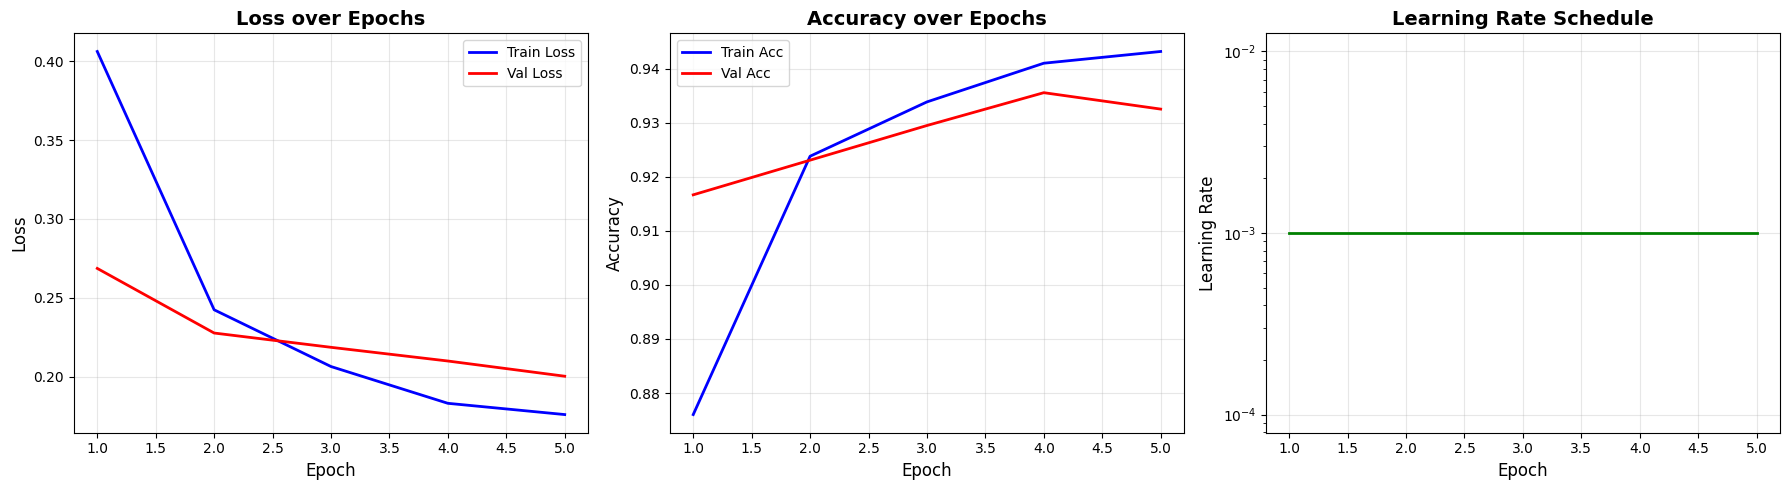

In [ ]:
print("PHASE 1: Training classifier head with frozen backbone")
print("="*60)

history_phase1 = train_model_finetuned(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=5,  # Fewer epochs for warm-up
    device=device,
    early_stopping_patience=3,
    checkpoint_path='ecosort_phase1.pth'
)

plot_training_history(history_phase1)


## Phase 2: Fine-tuning with unfrozen backbone layers



PHASE 2: Fine-tuning with unfrozen backbone
Loaded Phase 1 best model (Val Acc: 0.9356)
Backbone partially unfrozen for fine-tuning (ResNet layer4)
Trainable parameters: 19,429,484 (69.46%)
Starting Training
  Batch [10/217] - Loss: 0.1350
  Batch [20/217] - Loss: 0.0957
  Batch [30/217] - Loss: 0.1285
  Batch [40/217] - Loss: 0.0846
  Batch [50/217] - Loss: 0.1995
  Batch [60/217] - Loss: 0.0692
  Batch [70/217] - Loss: 0.0905
  Batch [80/217] - Loss: 0.1114
  Batch [90/217] - Loss: 0.1088
  Batch [100/217] - Loss: 0.1253
  Batch [110/217] - Loss: 0.1136
  Batch [120/217] - Loss: 0.0832
  Batch [130/217] - Loss: 0.0782
  Batch [140/217] - Loss: 0.1166
  Batch [150/217] - Loss: 0.2294
  Batch [160/217] - Loss: 0.0861
  Batch [170/217] - Loss: 0.1202
  Batch [180/217] - Loss: 0.0758
  Batch [190/217] - Loss: 0.1160
  Batch [200/217] - Loss: 0.1322
  Batch [210/217] - Loss: 0.1508

Epoch [1/15]
  Train Loss: 0.1274 | Train Acc: 0.9576
  Val Loss:   0.1650 | Val Acc:   0.9484
  Learning

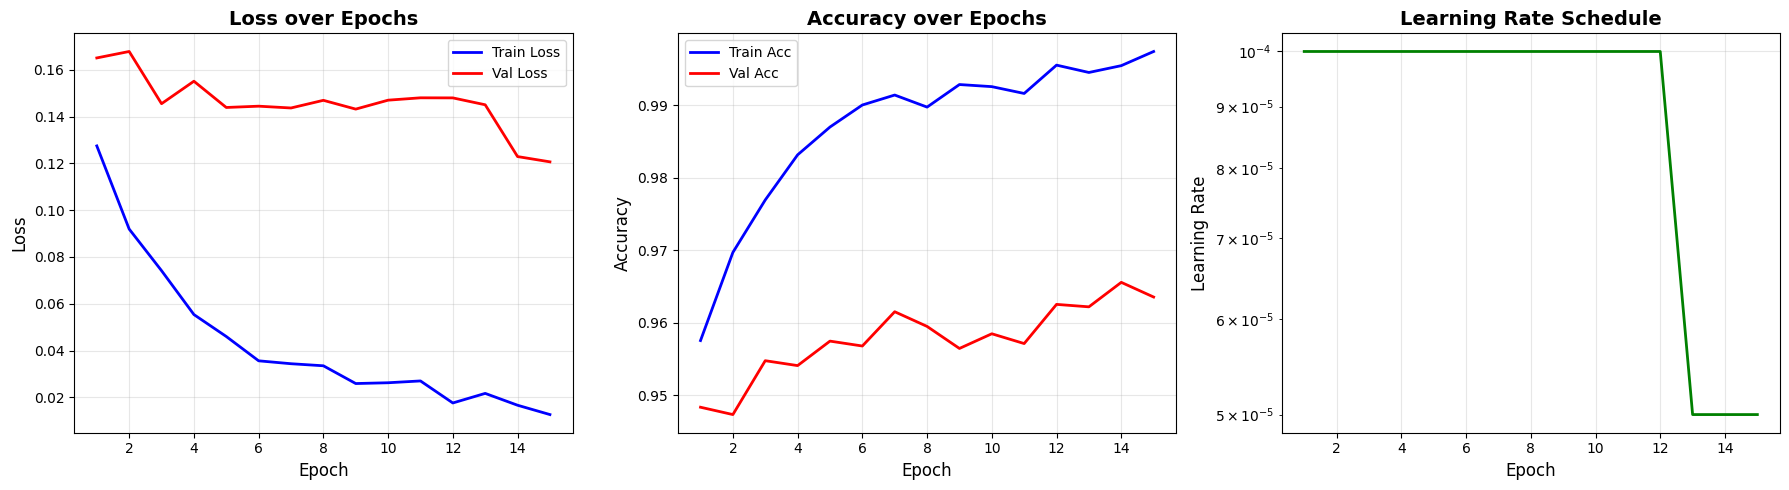

In [ ]:
print("\n\nPHASE 2: Fine-tuning with unfrozen backbone")
print("="*60)

# Loading best model from Phase 1
checkpoint = torch.load('ecosort_phase1.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded Phase 1 best model (Val Acc: {checkpoint['val_acc']:.4f})")

model.unfreeze_backbone()

# Creating new optimizer with lower learning rate for fine-tuning
fine_tune_lr = 0.0001
optimizer_finetune = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=fine_tune_lr,
    weight_decay=1e-4
)

scheduler_finetune = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_finetune,
    mode='min',
    factor=0.5,
    patience=3
)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,} ({100 * trainable_params / total_params:.2f}%)")

# TRAINING!
history_phase2 = train_model_finetuned(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_finetune,
    scheduler=scheduler_finetune,
    num_epochs=15,
    device=device,
    early_stopping_patience=5,
    checkpoint_path='ecosort_best_model.pth'
)

plot_training_history(history_phase2)


## Evaluating on test set

In [ ]:
print("\n\nFINAL EVALUATION ON TEST SET")
print("="*60)

# Loading the best model
checkpoint = torch.load('ecosort_best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

test_accuracy = calculate_accuracy(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

@torch.no_grad()
def evaluate_per_class(model, dataloader, device, class_names):
    """Evaluate model performance per class"""
    model.eval()
    class_correct = [0] * len(class_names)
    class_total = [0] * len(class_names)

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)

        for label, prediction in zip(labels, predictions):
            class_total[label] += 1
            if label == prediction:
                class_correct[label] += 1

    print("\nPer-Class Accuracy:")
    print("-" * 40)
    for i, class_name in enumerate(class_names):
        if class_total[i] > 0:
            accuracy = class_correct[i] / class_total[i]
            print(f"{class_name:20s}: {accuracy:.4f} ({class_correct[i]}/{class_total[i]})")
        else:
            print(f"{class_name:20s}: No samples")

evaluate_per_class(model, test_loader, device, full_dataset.classes)




FINAL EVALUATION ON TEST SET
Test Accuracy: 0.9669 (96.69%)

Per-Class Accuracy:
----------------------------------------
battery             : 0.9820 (109/111)
biological          : 0.9551 (149/156)
cardboard           : 0.9717 (275/283)
clothes             : 0.9852 (800/812)
glass               : 0.9780 (445/455)
metal               : 0.9752 (157/161)
paper               : 0.9516 (236/248)
plastic             : 0.9216 (282/306)
shoes               : 0.9763 (288/295)
trash               : 0.9275 (128/138)


## Visualizing confusion matrix and calculating Top-1, Top-5 and F1 score

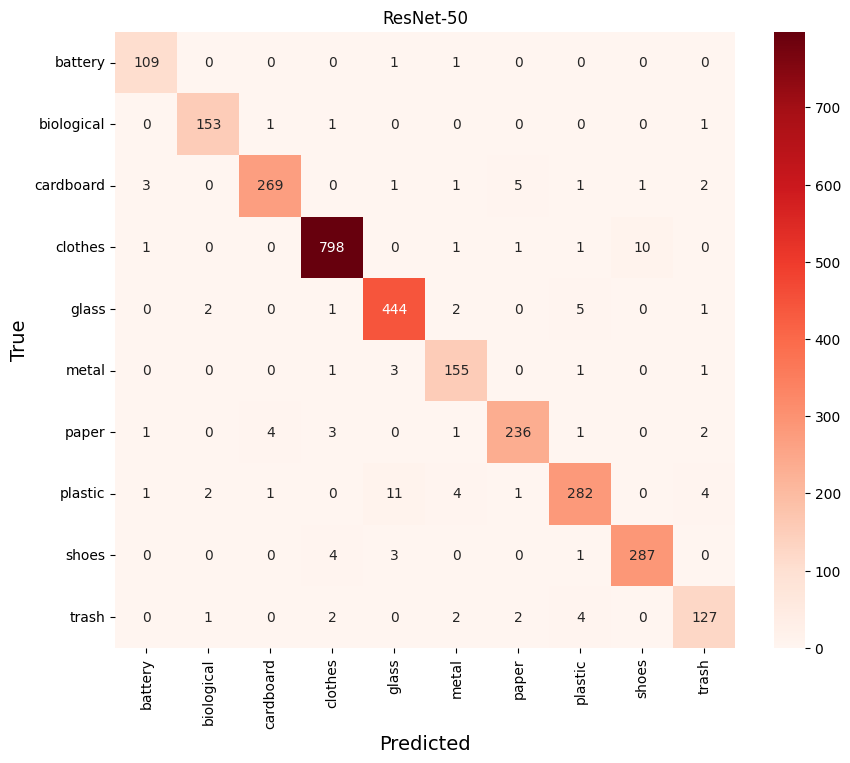


Top-1: 0.9646
Top-5: 0.9997
F1 Score (Macro Avg): 0.9582


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sea

def visualize_confusion_matrix(model, dataloader, class_names):
    model.eval()
    prediction_labels = []
    targets = []
    all_outputs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            prediction_labels.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())
            all_outputs.append(outputs.cpu())

    cm = confusion_matrix(targets, prediction_labels)

    plt.figure(figsize=(10, 8))
    sea.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.title('ResNet-50')
    plt.show()

    top1 = accuracy_score(targets, prediction_labels)
    f1 = f1_score(targets, prediction_labels, average='macro')

    all_outputs = torch.cat(all_outputs)
    _, top5_predictions = torch.topk(all_outputs, 5, dim=1)
    top5 = 0.0
    for i in range(len(targets)):
        if targets[i] in top5_predictions[i]:
            top5 += 1
    top5 /= len(targets)

    print(f"\nTop-1: {top1:.4f}")
    print(f"Top-5: {top5:.4f}")
    print(f"F1 Score (Macro Avg): {f1:.4f}")

class_names = full_dataset.classes
visualize_confusion_matrix(model, test_loader, class_names)

## Helper functions for model saving and loading

In [ ]:
def save_complete_model(model, filepath, additional_info=None):
    """Save complete model with metadata"""
    save_dict = {
        'model_state_dict': model.state_dict(),
        'model_architecture': model.__class__.__name__,
        'num_classes': len(full_dataset.classes),
        'class_names': full_dataset.classes,
    }

    if additional_info:
        save_dict.update(additional_info)

    torch.save(save_dict, filepath)
    print(f"✓ Model saved to {filepath}")


def load_complete_model(filepath, device):
    """Load complete model with metadata"""
    checkpoint = torch.load(filepath, map_location=device)

    # Recreate model
    model = EcoSortFineTunedModel(
        num_classes=checkpoint['num_classes'],
        freeze_backbone=False
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()

    print(f"✓ Model loaded from {filepath}")
    print(f"  Classes: {checkpoint['class_names']}")

    return model, checkpoint


# Saving the final trained model with metadata
save_complete_model(
    model=model,
    filepath='ecosort_final_model.pth',
    additional_info={
        'test_accuracy': test_accuracy,
        'training_date': '2025-10-29'
    }
)


✓ Model saved to ecosort_final_model.pth


## FINAL INFERENCE WITH VISUALIZATION!!!

Sample Predictions on Test Set:


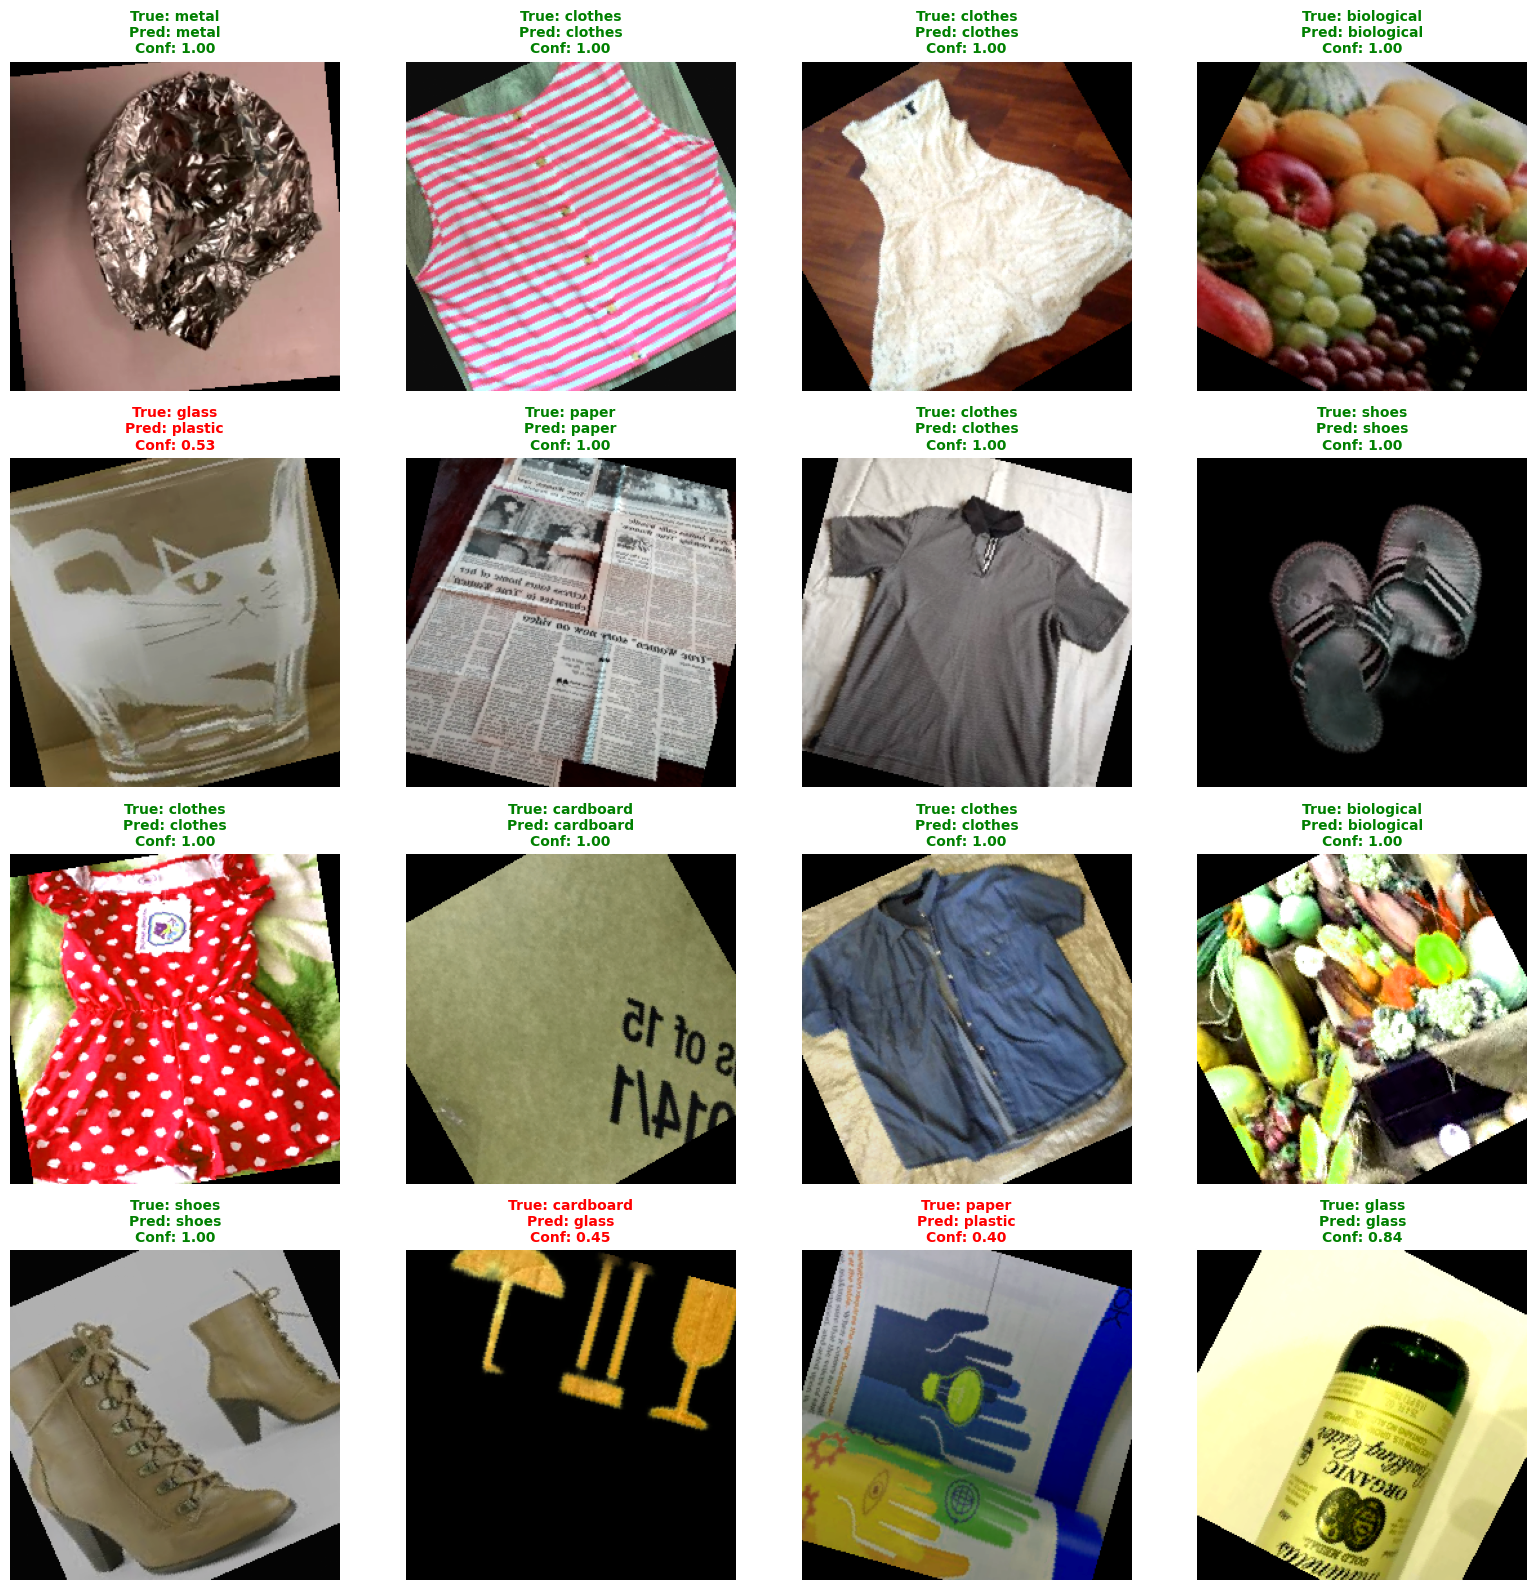

In [ ]:
def visualize_predictions(model, dataset, device, num_samples=16):
    """Visualize model predictions on random samples"""
    model.eval()

    # Getting RANDOM samples
    indices = torch.randint(0, len(dataset), (num_samples,))

    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    axes = axes.ravel()

    with torch.no_grad():
        for idx, sample_idx in enumerate(indices):
            image, true_label = dataset[sample_idx]

            # Prediction
            image_batch = image.unsqueeze(0).to(device)
            output = model(image_batch)
            pred_label = torch.argmax(output, dim=1).item()
            confidence = torch.softmax(output, dim=1)[0, pred_label].item()

            # We must denormalize image for display
            img_display = image.cpu().clone()
            for t, m, s in zip(img_display, IMAGENET_MEAN, IMAGENET_STD):
                t.mul_(s).add_(m)
            img_display = torch.clamp(img_display, 0, 1)

            axes[idx].imshow(img_display.permute(1, 2, 0))
            axes[idx].axis('off')

            true_class = full_dataset.classes[true_label]
            pred_class = full_dataset.classes[pred_label]

            color = 'green' if true_label == pred_label else 'red'
            axes[idx].set_title(
                f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2f}',
                fontsize=10,
                color=color,
                weight='bold'
            )

    plt.tight_layout()
    plt.show()

print("Sample Predictions on Test Set:")
visualize_predictions(model, test_dataset, device, num_samples=16)


Overall, very impressive capabilites and results from our final model (we were certainly satisfied)! More in-depth details in our report.